- Setup contains the code use to construct and evaluate PHBF.
- For the project, the final results are from the Section "Network Attacks" and the plots are placed in "Plots"

# Setup

In [376]:
import pandas as pd
import numpy as np
import copy

In [377]:
class PHBF:
    def __init__(self, m=4096, k=11, s=10000):
        self.m = m
        self.k = k
        self.s = s
        self.delta = m // k
        self.bitarr = np.zeros(m, dtype=bool)
        self.vecs = []
        self.colls = []
        self.vect = HashingVectorizer(analyzer='char', ngram_range=(3,5), n_features=512)
        self.v = 0
        self.X = None
        self.Y = None
        
    def select_vectors(self, Xp, Yp, d):
        cand = np.random.randn(self.s, d)

        best = []
        coll = []

        for v in cand:
            v /= np.linalg.norm(v)
            Xh = np.floor((Xp @ v) * self.delta).astype(int)
            Yh = np.floor((Yp @ v) * self.delta).astype(int)

            c = len(set(Xh) & set(Yh))
            coll.append((c, v))
        coll.sort(key=lambda x: x[0])
        self.vecs = [v for _, v in coll[:self.k]]
        self.colls = [c for c, _ in coll[:self.k]]

    def hash(self, xv, w, i, p=None):
        proj = xv @ w
        proj /= np.linalg.norm(xv)
        _bin = abs(int(proj*self.delta))
        return abs(hash((i, round(proj, 3)))) % self.m
    
    def fit(self, df=None, X=None, Y=None, method=None):
        if not method:
            Xp = X.values
            Yp = Y.values
        else:
            Xp = X.sample(int(method(len(X)))).values
            Yp = Y.sample(int(method(len(Y)))).values
        
        self.X = X.values
        self.Y = Y.values

        d = Xp.shape[1]     

        self.select_vectors(Xp, Yp, d)
        for x in X.values:
            for i, w in enumerate(self.vecs):
                idx = self.hash(x, w, i)
                self.bitarr[idx] = True

    def add(self, xv):
        for i, w in enumerate(self.vecs):
            idx = self.hash(xv, w, i)
            self.bitarr[idx] = True

    def query(self, url, p=None):
        f = []
        if p:
            print(self.vecs)
        for i, w in enumerate(self.vecs):
            idx = self.hash(url, w, i, p=False)
            f.append(idx)
            if not self.bitarr[idx]:
                return False, f 

        return True, f

    def eval(self):
        fn, fp = 0, 0 
        for i in self.X:
            if not self.query(i)[0]:
                fn += 1

        for i in self.Y:
            if self.query(i)[0]:
                fp += 1

        return (fn / len(self.X), fp / len(self.Y))

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from collections import Counter

# Network Attacks

In [31]:

features = """duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: continuous.
dst_host_same_srv_rate: continuous.
dst_host_diff_srv_rate: continuous.
dst_host_same_src_port_rate: continuous.
dst_host_srv_diff_host_rate: continuous.
dst_host_serror_rate: continuous.
dst_host_srv_serror_rate: continuous.
dst_host_rerror_rate: continuous.
dst_host_srv_rerror_rate: continuous.
"""
features = [i.split(":")[0] for i in features.split("\n")]
features[-1] = "attack_type"

deef = pd.read_csv('http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz', header=None, names=features)

In [32]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(feature_name_combiner='concat')
f = ohe.fit_transform(deef[['protocol_type', 'service', 'flag']])
k = pd.DataFrame(f.toarray(), columns=ohe.get_feature_names_out())
k.head()
deef = deef.drop(['protocol_type', 'service', 'flag'],axis=1)
deef = pd.concat([deef, k], axis=1)

# Tests

## Fix m, iterate k

In [320]:
var_k = {}

In [335]:
def exp1(m=2048, samples=2000):
    import statistics

    teef = deef.sample(samples)
    tx = teef[teef['attack_type'] == 'normal.'].drop(['attack_type'], axis=1)
    ty = teef[teef['attack_type'] != 'normal.'].drop(['attack_type'], axis=1)
    tx = tx.fillna(0)
    ty = ty.fillna(0)
    len(tx), len(ty)

    k_results = []
    k_headers = ['Bit Array Size', 'Capacity', 'Hash Functions (k)', 'FPR Mean', 'FPR Median', 'FPR Variance', 'FPR Range']
    
    for k in [4, 8, 16, 32, 64]:
        temp = []
        for _ in range(30):
            _p = PHBF(m=m, k=k)
            _p.fit(teef, X=tx, Y=ty)
            a, b = _p.eval()
            temp.append(b)
        var_k[(m,k)] = temp
            
        k_results.append([m, samples, k, statistics.mean(temp), statistics.median(temp), statistics.variance(temp), max(temp) - min(temp)])
    
    return pd.DataFrame(k_results, columns=k_headers)

In [336]:
exp1()
exp1(m=4096, samples=4000)
exp1(m=16192, samples=16000)

---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
---------------
--------

,Bit Array Size,Capacity,Hash Functions (k),FPR Mean,FPR Median,FPR Variance,FPR Range
0,16192,16000,4,0.273622,0.072453,0.092146,0.715177
1,16192,16000,8,0.290272,0.032466,0.094739,0.711123
2,16192,16000,16,0.065586,0.002923,0.035470,0.686492
3,16192,16000,32,0.001985,0.001754,0.000001,0.006548
4,16192,16000,64,0.020706,0.001442,0.010906,0.573310


In [337]:
with open('var_k64_30.pkl', 'wb') as f:
    pickle.dump(var_k, f)

## Training v/s Test data

In [249]:
_subp1 = PHBF(m=4086, k=16)
_subp2 = PHBF(m=4086, k=16)

In [250]:
sah = deef.sample(4000)
sx = sah[sah['attack_type'] == 'normal.'].drop(['attack_type'], axis=1)
sy = sah[sah['attack_type'] != 'normal.'].drop(['attack_type'], axis=1)
_subp1.fit(sah, X=sx, Y=sy, method=math.sqrt)

---------------


In [251]:
_subp1.eval()

(0.0, 0.0033773411114522566)

In [254]:
#build baseline phbf 
def choose_best(samples=16384, method=None):
    teef = deef.sample((samples // 1000) * 1000)
    tx = teef[teef['attack_type'] == 'normal.'].drop(['attack_type'], axis=1)
    ty = teef[teef['attack_type'] != 'normal.'].drop(['attack_type'], axis=1)
    tx = tx.fillna(0)
    ty = ty.fillna(0)
    print(len(tx), len(ty))
    
    mn, p_tr = float('inf'), None
    if samples > 16000:
        k = 32
    else:
        k = 16
    for _ in range(5):
        _p = PHBF(m=samples, k=k)
        _p.fit(teef, X=tx, Y=ty,method=method)
        a, b = _p.eval()
        if b < mn and b > 0:
            p_tr = _p
            mn = b

    return p_tr

In [255]:
n_best = [choose_best(samples=i) for i in [2048, 4086, 8196, 16384]]
sqrt_best = [choose_best(samples=i, method=math.sqrt) for i in [2048, 4086, 8196, 16384]]
logn_best = [choose_best(samples=i, method=math.log) for i in [2048, 4086, 8196, 16384]]

420 1580
---------------
---------------
---------------
---------------
---------------
780 3220
---------------
---------------
---------------
---------------
---------------
1568 6432
---------------
---------------
---------------
---------------
---------------
3216 12784
---------------
---------------
---------------
---------------
---------------
402 1598
---------------
---------------
---------------
---------------
---------------
757 3243
---------------
---------------
---------------
---------------
---------------
1656 6344
---------------
---------------
---------------
---------------
---------------
3190 12810
---------------
---------------
---------------
---------------
---------------
383 1617
---------------
---------------
---------------
---------------
---------------
785 3215
---------------
---------------
---------------
---------------
---------------
1591 6409
---------------
---------------
---------------
---------------
---------------
3210 12790
---

In [256]:
with open('sqrt_log.pkl', 'wb') as f:
    pickle.dump([n_best, sqrt_best, logn_best], f)

In [310]:
def subsampling(method=None, itr=40):
    teef = deef.sample(12000)
    tx = teef[teef['attack_type'] == 'normal.'].drop(['attack_type'], axis=1)
    ty = teef[teef['attack_type'] != 'normal.'].drop(['attack_type'], axis=1)
    tx = tx.fillna(0)
    ty = ty.fillna(0)
    print(len(tx), len(ty))

    n_best = []
    
    for m in [2048, 4086, 8196, 16384]:
        print(m)
        mn, p_tr = float('inf'), []
        if m > 16000:
            k = 32
        else:
            k = 16
        for _ in range(itr):
            _p = PHBF(m=m, k=k)
            _p.fit(teef, X=tx, Y=ty,method=method)
            a, b = _p.eval()
            p_tr.append(_p.eval()[1])
        
        n_best.append(statistics.median(p_tr))

    return n_best

In [311]:
def plot_diff(itr=40):
    n_best = subsampling()
    sqrt_best = subsampling(method=math.sqrt)
    logn_best = subsampling(method=math.log)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    labels = [2048, 4096, 8192, 16384]
    axes.plot(labels, n_best, label='linear', marker='o')
    axes.plot(labels, sqrt_best, label='sqrt', marker='o')
    axes.plot(labels, logn_best, label='log', marker='o')
    axes.set_yscale('log')
    axes.grid(True)
    axes.legend()
    return n_best, sqrt_best, logn_best

In [ ]:
nb, sqb, logb = plot_diff(20)

## Plots

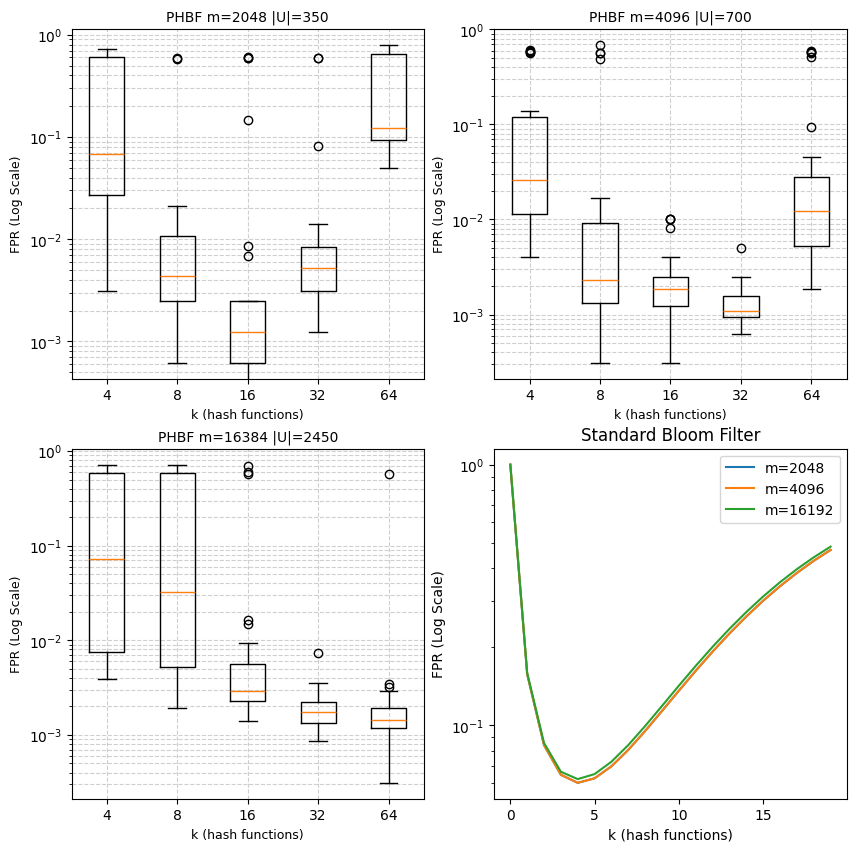

In [371]:
def plot_var_k():
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    for i, m in zip([0,1,2],[2048, 4096, 16192]):
        data = [var_k[(m, i)] for i in [4, 8, 16, 32, 64]]
        labels = [4, 8, 16, 32, 64]
        # plt.figure(figsize=(3, 3))
        ps = [pow(1 - math.exp(-k / (m / (350 * ((math.ceil(m/2048) * 2048) // 2048)))), k) for k in range(20)]
        axes[1][1].plot(list(range(20)), ps, label=f'm={m}')
        axes[1][1].set_xlabel('k (hash functions)')
        axes[1][1].set_ylabel('FPR (Log Scale)')
        axes[1][1].set_yscale('log')
        axes[1][1].set_title('Standard Bloom Filter')
        axes[1][1].legend()
        axes[i//2][i%2].boxplot(data, tick_labels=labels, showfliers=True)
        axes[i//2][i%2].set_yscale('log')
        axes[i//2][i%2].set_xlabel('k (hash functions)', fontsize=9)
        axes[i//2][i%2].set_ylabel('FPR (Log Scale)', fontsize=9)
        axes[i//2][i%2].set_title(f'PHBF m={math.ceil(m/2048) * 2048} |U|={int(350 * (m // 2048))}', fontsize=10)
        axes[i//2][i%2].grid(True, which='both', linestyle='--', alpha=0.6)
        # ax.tight_layout()
    plt.show()
    fig.savefig("var_k.png", dpi=300, bbox_inches='tight')

plot_var_k()

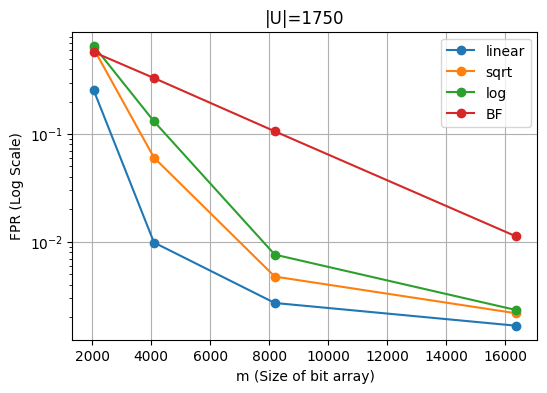

In [373]:
stand = []
for m in [2048, 4096, 8192, 16384]:
    n = 350 * (12000 // 2048)
    k = round((m / n) * math.log(2))
    stand.append(math.pow(1 - math.exp(-k / (m / n)), k))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
labels = [2048, 4096, 8192, 16384]
axes.plot(labels, nb, label='linear', marker='o')
axes.plot(labels, sqb, label='sqrt', marker='o')
axes.plot(labels, logb, label='log', marker='o')
axes.plot(labels, stand, label='BF', marker='o')
axes.set_yscale('log')
axes.set_xlabel('m (Size of bit array)')
axes.set_ylabel('FPR (Log Scale)')
axes.set_title(f'|U|={350 * (12000 // 2048)}')
axes.grid(True)
axes.legend()
plt.show()
fig.savefig('comp.png', dpi=300, bbox_inches='tight')

In [370]:
def k(m,n):
    return round((m/n)*log(2))

def fpr(m,n):
    _k = k(m,n)
    return (1 - exp(-_k * n / m)) ** _k

import math

def plot_vs_bf():
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
    for i, m in zip([0,1,2], [2048, 4096, 16192]):
        data = [statistics.median(var_k[(m, k)]) for k in [4, 8, 16, 32]]
        labels = [4, 8, 16, 32]
        data_bf = [math.pow(1 - math.exp(-k / (m / 350 * (m // 2048))), k) for k in [4, 8, 16, 32]]
        axes[i//2,i%2].grid(True)
        axes[i//2,i%2].plot(labels, data)
        axes[i//2,i%2].set_yscale('log')
        axes[i//2,i%2].set_xticks(labels)
        axes[i//2, i%2].plot(labels, data_bf)
    plt.show()

In [374]:
def test_unseen(pcl=None):
    p = copy.deepcopy(pcl)
    teef = deef.sample(len(p.X) + len(p.Y))

    new_fpr = [p.eval()[1]]
    entries_added = [0]
    
    tx = teef[teef['attack_type'] == 'normal.'].drop(['attack_type'], axis=1)
    ty = teef[teef['attack_type'] != 'normal.'].drop(['attack_type'], axis=1)
    tx = tx.fillna(0)
    ty = ty.fillna(0)
    print(len(tx), len(ty))

    fn, fp = 0, 0

    for i in tx.values:
        if not p.query(i)[0]:
            fn += 1
    for i in ty.values:
        if p.query(i)[0]:
            fp += 1

    print(fn / len(tx), fp / len(ty))

    de = int(0.01 * len(p.X))
    for it in range(50):
        for i in tx.values[it*de:it*de+de]:
            if not p.query(i)[0]:
                p.add(i)

        fp = 0
        for i in np.vstack((ty.values,p.Y)):
            if p.query(i)[0]:
                fp += 1
                
        new_fpr.append(fp / (len(ty) + len(p.Y)))
        entries_added.append(it*1+1)

    return (new_fpr, entries_added)

425 1575
0.36470588235294116 0.0012698412698412698
813 3187
0.2693726937269373 0.0006275494195167869
3154 12846
0.06785034876347495 0.0028024287716020553


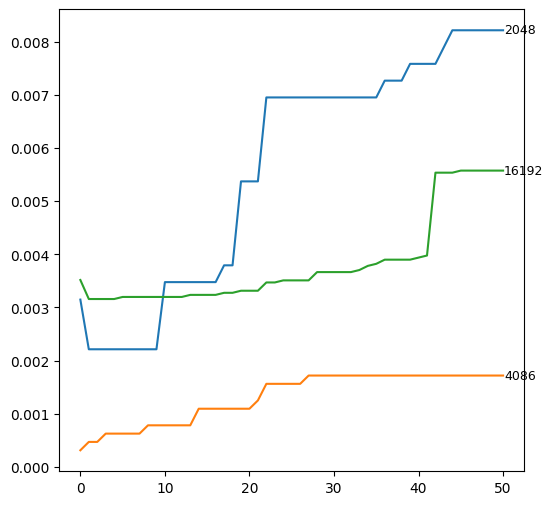

In [378]:
unseen = {}
for idx, i in enumerate([2048, 4086, 16192]):
    unseen[i] = test_unseen(pcl=best_models[idx])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
for i in [2048, 4086, 16192]:
    first = unseen[i][0][0]
    axes.plot(unseen[i][1], unseen[i][0], label=f'{i}')
    axes.text(unseen[i][1][-1] + 0.1, unseen[i][0][-1], f'{i}', fontsize=9, va='center')